In [1]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt

import datetime as dt
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten,Reshape, LeakyReLU, BatchNormalization, UpSampling2D, Conv2D, Embedding, Concatenate, Multiply, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

devices = tf.config.list_physical_devices('GPU')
tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(devices[0], 'GPU')

def bulid_generator(latent_dim, class_num, img_shape):
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(class_num,), dtype='float32')

    # ラベルをくっつける
    model_input = Concatenate()([noise, label])

    size = img_shape[0] // 4

    hid = Dense(128 * size * size, activation="relu")(model_input)
    hid = Reshape((size, size, 128))(hid)
    hid = UpSampling2D()(hid)

    hid = Conv2D(128, kernel_size=3, padding="same")(hid)
    hid = BatchNormalization(momentum=0.8)(hid)
    hid = Activation("relu")(hid)
    hid = UpSampling2D()(hid)

    hid = Conv2D(64, kernel_size=3, padding="same")(hid)
    hid = BatchNormalization(momentum=0.8)(hid)
    hid = Activation("relu")(hid)

    hid = Conv2D(img_shape[2], kernel_size=3, padding="same")(hid)
    img = Activation("tanh")(hid)

    return Model([noise, label], img)

def build_discriminator(img_shape):
    img = Input(shape=img_shape)
    label = Input(shape=(class_num,), dtype='float32')

    hid = Conv2D(32, kernel_size=3, strides=2, padding="same")(img)
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2D(64, kernel_size=3, strides=2, padding="same")(hid)
    hid = BatchNormalization(momentum=0.8)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2D(128, kernel_size=3, strides=2, padding="same")(hid)
    hid = BatchNormalization(momentum=0.8)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2D(256, kernel_size=3, strides=2, padding="same")(hid)
    hid = BatchNormalization(momentum=0.8)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = Flatten()(hid)

    # ラベルをマージ
    merge = Concatenate()([hid, label])

    hid = Dense(512, activation="relu")(merge)
    validity = Dense(1, activation="sigmoid")(hid)

    return Model([img, label], validity)

def label2onehot(labels, class_num):
    return np.identity(class_num)[labels.reshape(labels.shape[0])]

def train(train_data, train_labels):
    # -1 ～ 1に
    train_data = train_data.astype(np.float32) / 127.5 - 1.0
    print(train_data.shape, train_label.shape)

    # モデル
    generator = bulid_generator(latent_dim, class_num, train_data.shape[1:])
    discriminator = build_discriminator(train_data.shape[1:])

    # 最適化関数
    optimizer = Adam(0.0002, 0.5)

    # Discriminatorコンパイル
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Generatorがノイズから画像を生成
    z = Input(shape=(latent_dim,))
    label = Input(shape=(class_num,))
    img = generator([z, label])

    discriminator.trainable = False
    valid = discriminator([img, label])

    # Generator学習用のモデル
    combined = Model([z, label], valid)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    gif_noise = np.random.normal(0, 1, (class_num, latent_dim))
    gif_labels = np.identity(class_num)
    stack_gif_img = []

    iterations = train_data.shape[0] / batch_size
    print('iterations:', iterations)

    
    # 　画像の真偽ラベルを準備
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        for i in range(int(iterations)-1):

            s = int(epoch * iterations) + i
            np.random.seed(s)
            idx = np.random.randint(0, train_data.shape[0], batch_size)

            # 学習画像をランダムで選ぶ
            imgs = train_data[idx]
            labels = train_label[idx]

            # Generatorが画像生成
            np.random.seed(s)
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict([noise, labels])

            # 本物画像と偽物画像を混ぜないと上手く学習してくれない
            d_imgs = np.concatenate([imgs, gen_imgs])
            np.random.seed(s)
            np.random.shuffle(d_imgs)
            
            d_labels = np.concatenate([labels, labels])
            np.random.seed(s)
            np.random.shuffle(d_labels)
            
            d_y = np.concatenate([real, fake])
            np.random.seed(s)
            np.random.shuffle(d_y)

            # 混合データを入れてDiscriminatorを学習
            d_loss = discriminator.train_on_batch([d_imgs, d_labels], d_y)

            # G を訓練（D が G の生成画像を誤って real 1 と判定するように訓練される）
            g_loss = combined.train_on_batch([noise, labels], real)

            # 生成画像を保存
            if i % 500 == 0:
                print(d_loss, g_loss)

                print("{}:{} [D loss: {}] [G loss: {}]".format(epoch, i, d_loss[0], g_loss))

                # 4行×ラベル数の画像を生成
                size = 4
                noise = np.random.normal(0, 1, (size * class_num, latent_dim))
                g_labels = np.tile(np.arange(class_num), size)
                g_labels = label2onehot(g_labels, class_num)
                gen_imgs = generator.predict([noise, g_labels])

                combine_images(log_path, gen_imgs, epoch, i, iterations, size)

def combine_images(log_path, gen_imgs, epoch, idx, iterations, size):
    r = size
    c = class_num
    
    # 生成画像を0-1に再スケール
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            img = gen_imgs[cnt, :, :, :]
            axs[i, j].imshow(img, cmap='gray' if img.shape[2] == 1 else 'viridis')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("{}/{}_{}.png".format(log_path, epoch, idx))
    plt.show()
    plt.close()

In [4]:
import gc
gc.collect()

44

In [6]:
class_num = 10

(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()
train_data = np.concatenate([train_x, test_x])
train_label = np.concatenate([train_y, test_y])

train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], train_data.shape[2], 1))
train_label = label2onehot(train_label, class_num)

latent_dim = 100
batch_size = 1000
epochs = 100

log_path = 'log/{}/images'.format(dt.datetime.now().strftime("%Y-%m-%d_%H%M%S"))
os.makedirs(log_path, exist_ok=True)

(70000, 28, 28, 1) (70000, 10)
iterations: 70.0
[0.6240858435630798, 0.7459999918937683] 0.6973311305046082
0:0 [D loss: 0.6240858435630798] [G loss: 0.6973311305046082]


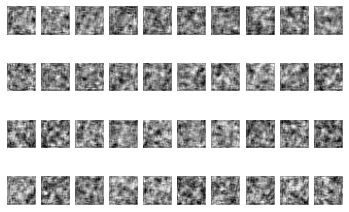

[0.3097226619720459, 0.8784999847412109] 1.8952162265777588
1:0 [D loss: 0.3097226619720459] [G loss: 1.8952162265777588]


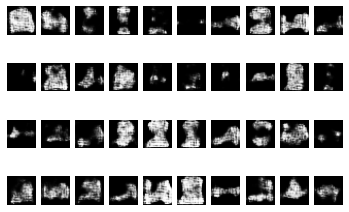

[0.2268257737159729, 0.9160000085830688] 2.1516292095184326
2:0 [D loss: 0.2268257737159729] [G loss: 2.1516292095184326]


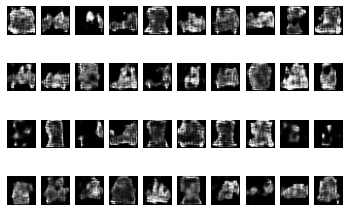

[0.13886472582817078, 0.9455000162124634] 1.6579163074493408
3:0 [D loss: 0.13886472582817078] [G loss: 1.6579163074493408]


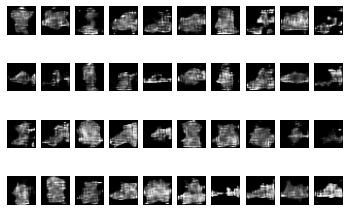

[0.17537283897399902, 0.9359999895095825] 2.6180179119110107
4:0 [D loss: 0.17537283897399902] [G loss: 2.6180179119110107]


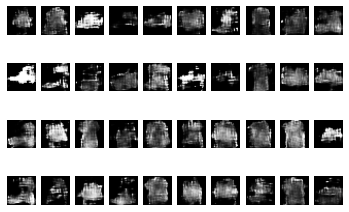

[0.2543737590312958, 0.8964999914169312] 2.616990566253662
5:0 [D loss: 0.2543737590312958] [G loss: 2.616990566253662]


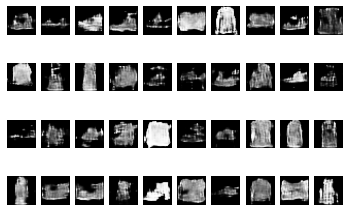

[0.25915253162384033, 0.8960000276565552] 1.4204509258270264
6:0 [D loss: 0.25915253162384033] [G loss: 1.4204509258270264]


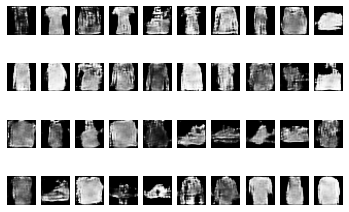

[0.2636692225933075, 0.8934999704360962] 1.7617295980453491
7:0 [D loss: 0.2636692225933075] [G loss: 1.7617295980453491]


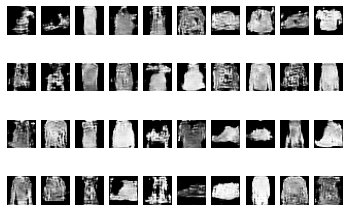

[0.31115686893463135, 0.8600000143051147] 2.1141257286071777
8:0 [D loss: 0.31115686893463135] [G loss: 2.1141257286071777]


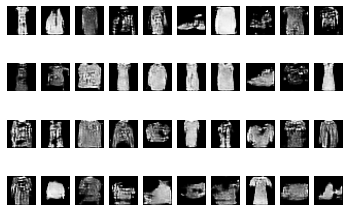

[0.24742434918880463, 0.906499981880188] 2.3946382999420166
9:0 [D loss: 0.24742434918880463] [G loss: 2.3946382999420166]


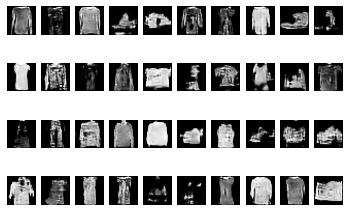

[0.32708993554115295, 0.8539999723434448] 2.237034797668457
10:0 [D loss: 0.32708993554115295] [G loss: 2.237034797668457]


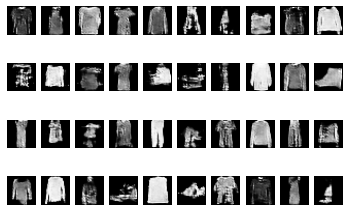

[0.41180717945098877, 0.8195000290870667] 1.7796478271484375
11:0 [D loss: 0.41180717945098877] [G loss: 1.7796478271484375]


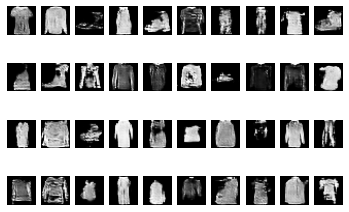

[0.2753926217556, 0.8934999704360962] 2.3091673851013184
12:0 [D loss: 0.2753926217556] [G loss: 2.3091673851013184]


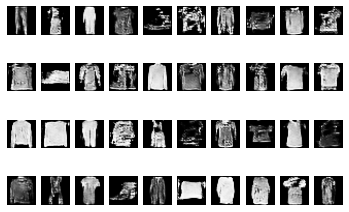

[0.286192387342453, 0.875] 2.2021889686584473
13:0 [D loss: 0.286192387342453] [G loss: 2.2021889686584473]


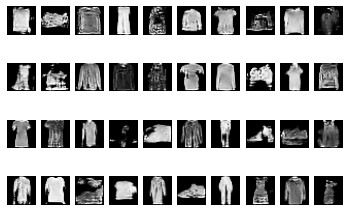

[0.28690871596336365, 0.8755000233650208] 1.655091643333435
14:0 [D loss: 0.28690871596336365] [G loss: 1.655091643333435]


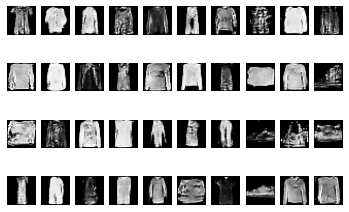

[0.2930399179458618, 0.8865000009536743] 2.866011619567871
15:0 [D loss: 0.2930399179458618] [G loss: 2.866011619567871]


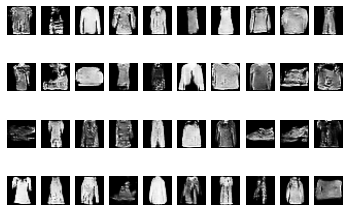

[0.3312222361564636, 0.8604999780654907] 3.308413505554199
16:0 [D loss: 0.3312222361564636] [G loss: 3.308413505554199]


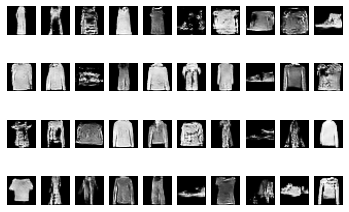

[0.2780713438987732, 0.8799999952316284] 2.5517656803131104
17:0 [D loss: 0.2780713438987732] [G loss: 2.5517656803131104]


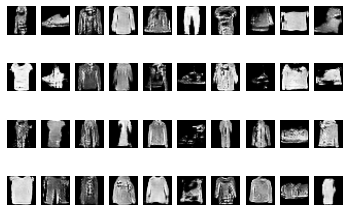

[0.31457746028900146, 0.8615000247955322] 2.8466854095458984
18:0 [D loss: 0.31457746028900146] [G loss: 2.8466854095458984]


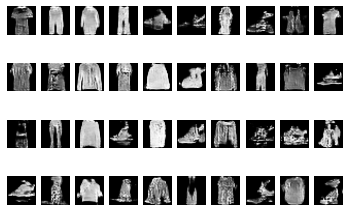

[0.27421027421951294, 0.8884999752044678] 2.729841709136963
19:0 [D loss: 0.27421027421951294] [G loss: 2.729841709136963]


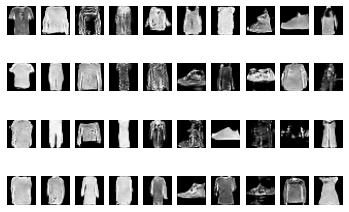

[0.3224279284477234, 0.8579999804496765] 1.6437106132507324
20:0 [D loss: 0.3224279284477234] [G loss: 1.6437106132507324]


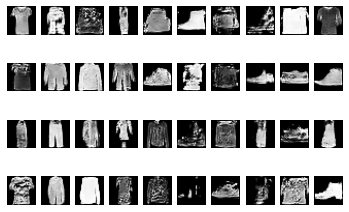

[0.3057190179824829, 0.8694999814033508] 2.6247124671936035
21:0 [D loss: 0.3057190179824829] [G loss: 2.6247124671936035]


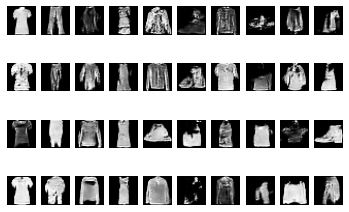

[0.3189332187175751, 0.859499990940094] 2.1194727420806885
22:0 [D loss: 0.3189332187175751] [G loss: 2.1194727420806885]


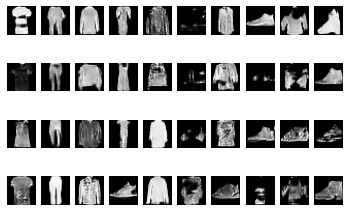

[0.2609819769859314, 0.9020000100135803] 1.3322501182556152
23:0 [D loss: 0.2609819769859314] [G loss: 1.3322501182556152]


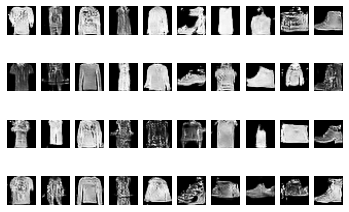

[0.45496711134910583, 0.7764999866485596] 0.9580318331718445
24:0 [D loss: 0.45496711134910583] [G loss: 0.9580318331718445]


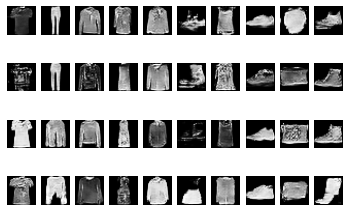

[0.3300822973251343, 0.8579999804496765] 2.1389882564544678
25:0 [D loss: 0.3300822973251343] [G loss: 2.1389882564544678]


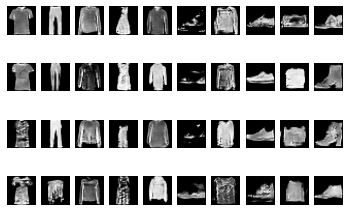

[0.40232837200164795, 0.8140000104904175] 1.918081283569336
26:0 [D loss: 0.40232837200164795] [G loss: 1.918081283569336]


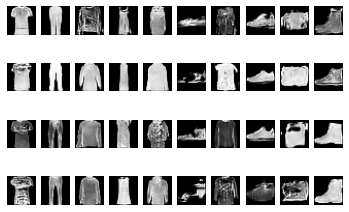

[0.3622630834579468, 0.8379999995231628] 1.3793061971664429
27:0 [D loss: 0.3622630834579468] [G loss: 1.3793061971664429]


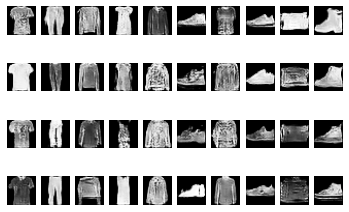

[0.4117288887500763, 0.815500020980835] 1.3655093908309937
28:0 [D loss: 0.4117288887500763] [G loss: 1.3655093908309937]


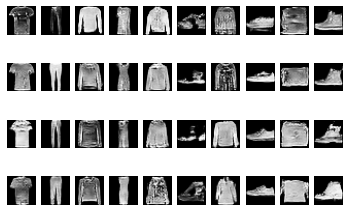

[0.45634132623672485, 0.7950000166893005] 1.4454352855682373
29:0 [D loss: 0.45634132623672485] [G loss: 1.4454352855682373]


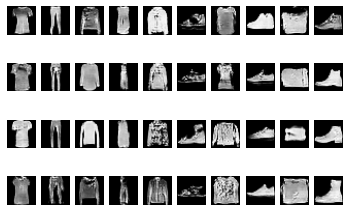

[0.39892542362213135, 0.8230000138282776] 1.6165072917938232
30:0 [D loss: 0.39892542362213135] [G loss: 1.6165072917938232]


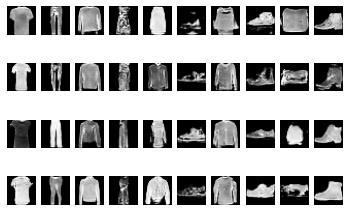

[0.38146308064460754, 0.8240000009536743] 1.8773294687271118
31:0 [D loss: 0.38146308064460754] [G loss: 1.8773294687271118]


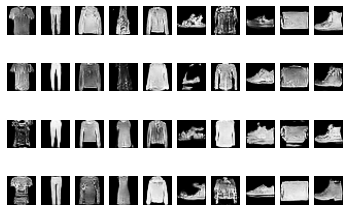

[0.402241587638855, 0.8184999823570251] 1.7107253074645996
32:0 [D loss: 0.402241587638855] [G loss: 1.7107253074645996]


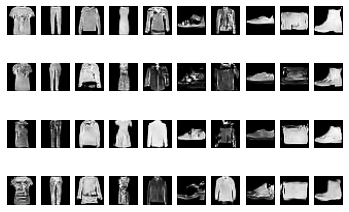

[0.39524027705192566, 0.8195000290870667] 1.6081392765045166
33:0 [D loss: 0.39524027705192566] [G loss: 1.6081392765045166]


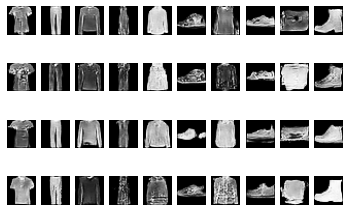

[0.43012550473213196, 0.7929999828338623] 1.4616917371749878
34:0 [D loss: 0.43012550473213196] [G loss: 1.4616917371749878]


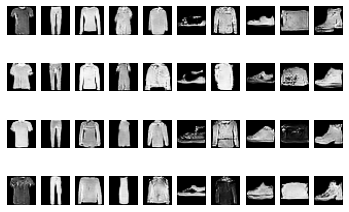

[0.40863531827926636, 0.8125] 1.248049259185791
35:0 [D loss: 0.40863531827926636] [G loss: 1.248049259185791]


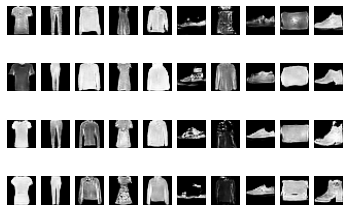

[0.40767034888267517, 0.8054999709129333] 1.9998334646224976
36:0 [D loss: 0.40767034888267517] [G loss: 1.9998334646224976]


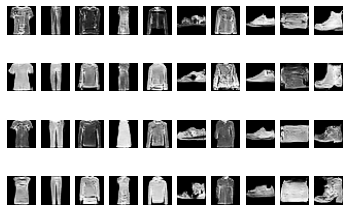

[0.4222421646118164, 0.8149999976158142] 1.8756054639816284
37:0 [D loss: 0.4222421646118164] [G loss: 1.8756054639816284]


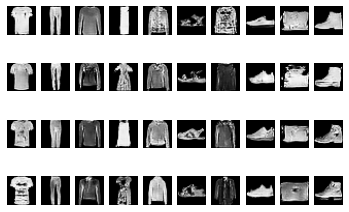

[0.38969069719314575, 0.828000009059906] 1.4285825490951538
38:0 [D loss: 0.38969069719314575] [G loss: 1.4285825490951538]


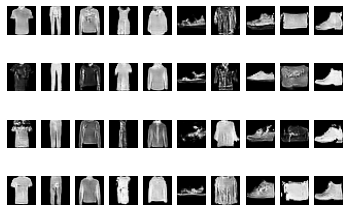

[0.3861832320690155, 0.8309999704360962] 2.032773971557617
39:0 [D loss: 0.3861832320690155] [G loss: 2.032773971557617]


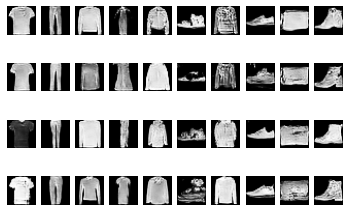

[0.3755514323711395, 0.8345000147819519] 1.627371072769165
40:0 [D loss: 0.3755514323711395] [G loss: 1.627371072769165]


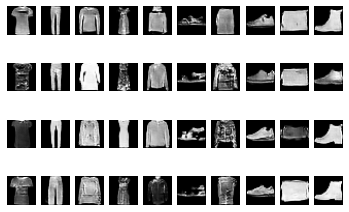

[0.397251695394516, 0.8100000023841858] 1.3558772802352905
41:0 [D loss: 0.397251695394516] [G loss: 1.3558772802352905]


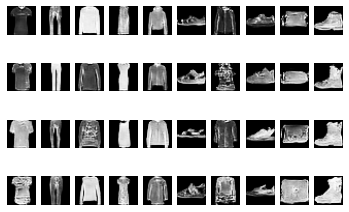

[0.3950875401496887, 0.8174999952316284] 1.3942309617996216
42:0 [D loss: 0.3950875401496887] [G loss: 1.3942309617996216]


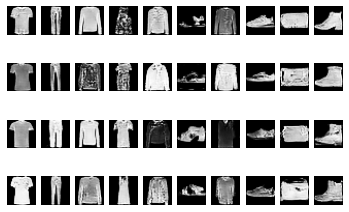

[0.3825278878211975, 0.8299999833106995] 1.0412968397140503
43:0 [D loss: 0.3825278878211975] [G loss: 1.0412968397140503]


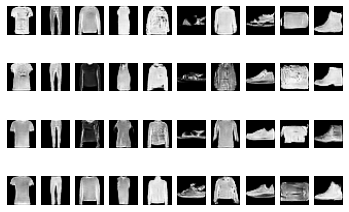

[0.39705413579940796, 0.8270000219345093] 1.416770100593567
44:0 [D loss: 0.39705413579940796] [G loss: 1.416770100593567]


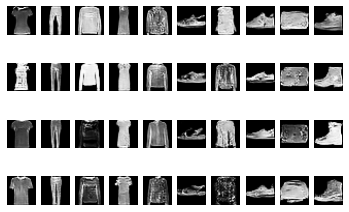

[0.40456053614616394, 0.8090000152587891] 3.081305980682373
45:0 [D loss: 0.40456053614616394] [G loss: 3.081305980682373]


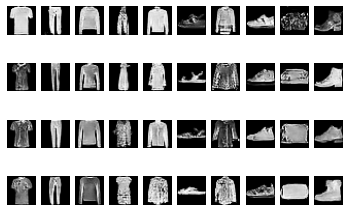

[0.3977833390235901, 0.8044999837875366] 1.0488042831420898
46:0 [D loss: 0.3977833390235901] [G loss: 1.0488042831420898]


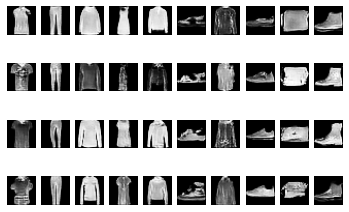

[0.37466567754745483, 0.8305000066757202] 1.5132744312286377
47:0 [D loss: 0.37466567754745483] [G loss: 1.5132744312286377]


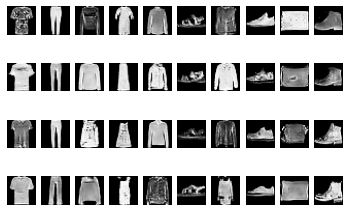

[0.38400474190711975, 0.8330000042915344] 1.6781342029571533
48:0 [D loss: 0.38400474190711975] [G loss: 1.6781342029571533]


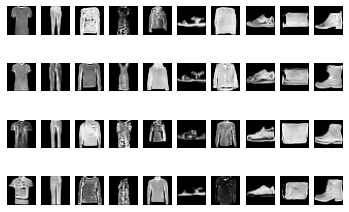

[0.36603838205337524, 0.8385000228881836] 2.161726951599121
49:0 [D loss: 0.36603838205337524] [G loss: 2.161726951599121]


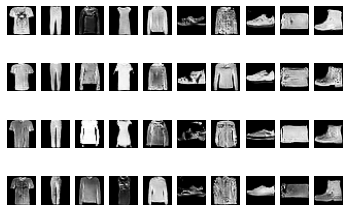

[0.40730637311935425, 0.8044999837875366] 1.0289183855056763
50:0 [D loss: 0.40730637311935425] [G loss: 1.0289183855056763]


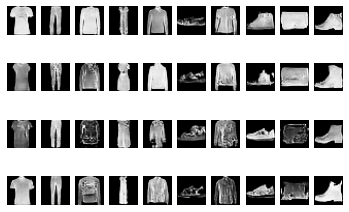

[0.3740033805370331, 0.824999988079071] 1.653617024421692
51:0 [D loss: 0.3740033805370331] [G loss: 1.653617024421692]


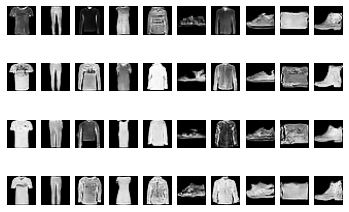

[0.39228731393814087, 0.8259999752044678] 2.2209503650665283
52:0 [D loss: 0.39228731393814087] [G loss: 2.2209503650665283]


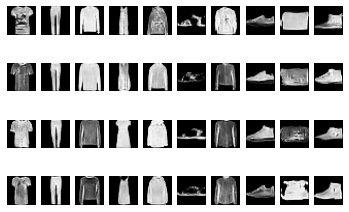

[0.364462673664093, 0.8345000147819519] 2.035712957382202
53:0 [D loss: 0.364462673664093] [G loss: 2.035712957382202]


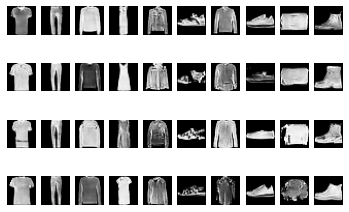

[0.3880411982536316, 0.8224999904632568] 2.5153896808624268
54:0 [D loss: 0.3880411982536316] [G loss: 2.5153896808624268]


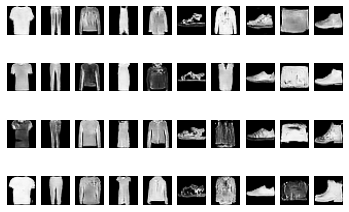

[0.35256972908973694, 0.843999981880188] 1.2164303064346313
55:0 [D loss: 0.35256972908973694] [G loss: 1.2164303064346313]


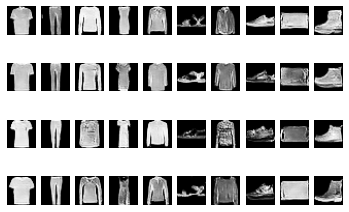

[0.44044727087020874, 0.7764999866485596] 2.5170421600341797
56:0 [D loss: 0.44044727087020874] [G loss: 2.5170421600341797]


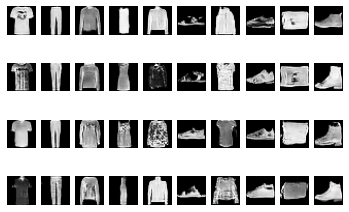

[0.3783861994743347, 0.8259999752044678] 1.17185378074646
57:0 [D loss: 0.3783861994743347] [G loss: 1.17185378074646]


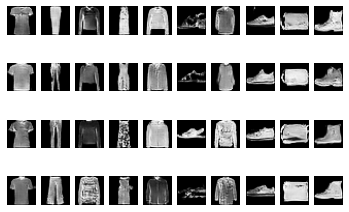

[0.3740096390247345, 0.8389999866485596] 2.3489861488342285
58:0 [D loss: 0.3740096390247345] [G loss: 2.3489861488342285]


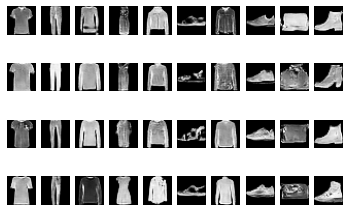

[0.35557666420936584, 0.8445000052452087] 1.7297136783599854
59:0 [D loss: 0.35557666420936584] [G loss: 1.7297136783599854]


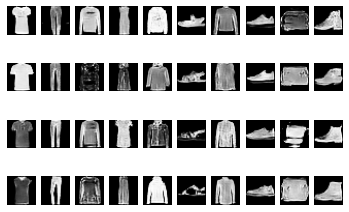

[0.35539498925209045, 0.8479999899864197] 1.6284428834915161
60:0 [D loss: 0.35539498925209045] [G loss: 1.6284428834915161]


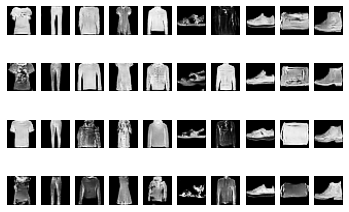

[0.375322163105011, 0.8245000243186951] 1.6876676082611084
61:0 [D loss: 0.375322163105011] [G loss: 1.6876676082611084]


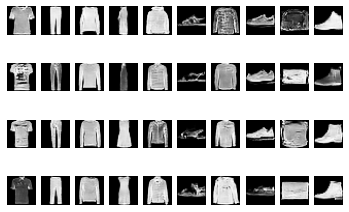

[0.3454134464263916, 0.8535000085830688] 1.1572893857955933
62:0 [D loss: 0.3454134464263916] [G loss: 1.1572893857955933]


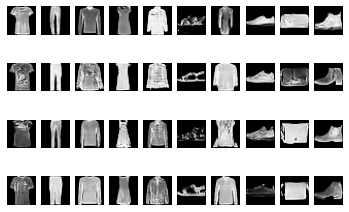

[0.36695951223373413, 0.8445000052452087] 2.1957130432128906
63:0 [D loss: 0.36695951223373413] [G loss: 2.1957130432128906]


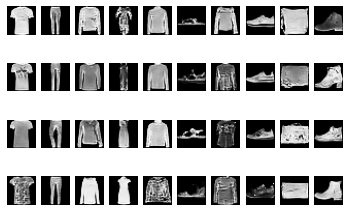

[0.350119948387146, 0.8429999947547913] 1.4594156742095947
64:0 [D loss: 0.350119948387146] [G loss: 1.4594156742095947]


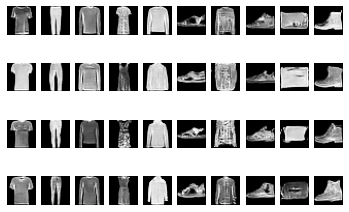

[0.3411405086517334, 0.8495000004768372] 1.8483480215072632
65:0 [D loss: 0.3411405086517334] [G loss: 1.8483480215072632]


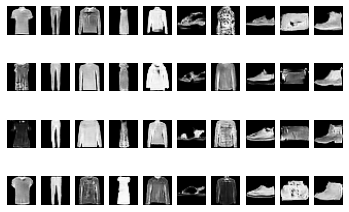

[0.3405573070049286, 0.859499990940094] 1.5141870975494385
66:0 [D loss: 0.3405573070049286] [G loss: 1.5141870975494385]


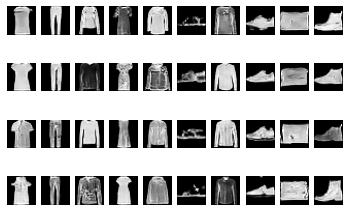

[0.31857311725616455, 0.8740000128746033] 2.0635342597961426
67:0 [D loss: 0.31857311725616455] [G loss: 2.0635342597961426]


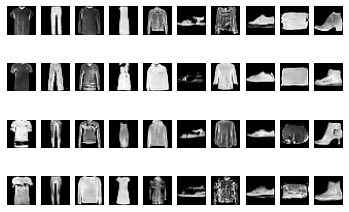

[0.36115914583206177, 0.8410000205039978] 2.495664119720459
68:0 [D loss: 0.36115914583206177] [G loss: 2.495664119720459]


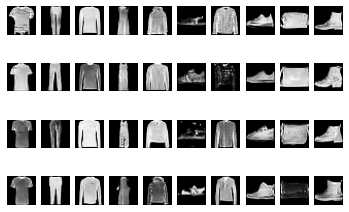

[0.33120104670524597, 0.8654999732971191] 1.9550608396530151
69:0 [D loss: 0.33120104670524597] [G loss: 1.9550608396530151]


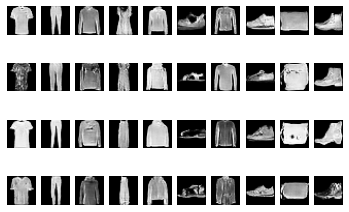

[0.37558478116989136, 0.8109999895095825] 1.5648107528686523
70:0 [D loss: 0.37558478116989136] [G loss: 1.5648107528686523]


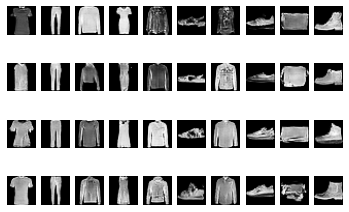

[0.3209134638309479, 0.8765000104904175] 1.3914629220962524
71:0 [D loss: 0.3209134638309479] [G loss: 1.3914629220962524]


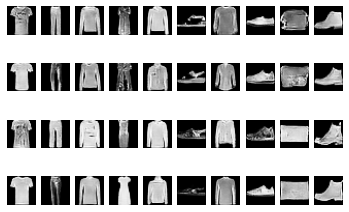

[0.3194196820259094, 0.8705000281333923] 2.629366397857666
72:0 [D loss: 0.3194196820259094] [G loss: 2.629366397857666]


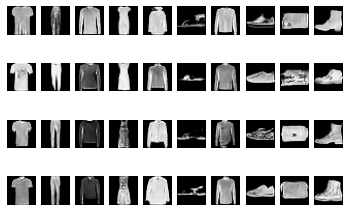

[0.34018582105636597, 0.8560000061988831] 2.350743293762207
73:0 [D loss: 0.34018582105636597] [G loss: 2.350743293762207]


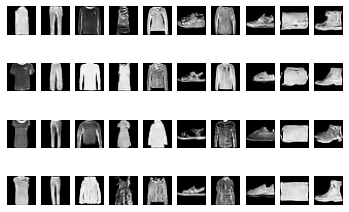

[0.3440413177013397, 0.8554999828338623] 1.6624114513397217
74:0 [D loss: 0.3440413177013397] [G loss: 1.6624114513397217]


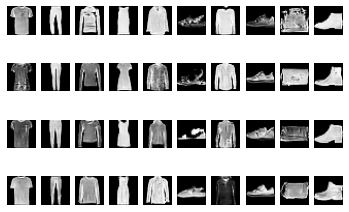

[0.3160877823829651, 0.8709999918937683] 3.0462005138397217
75:0 [D loss: 0.3160877823829651] [G loss: 3.0462005138397217]


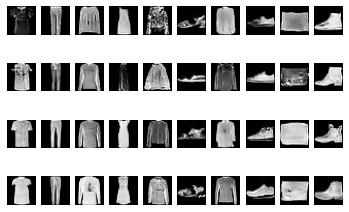

[0.3194471001625061, 0.862500011920929] 2.020193576812744
76:0 [D loss: 0.3194471001625061] [G loss: 2.020193576812744]


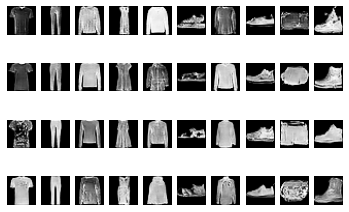

[0.3134610652923584, 0.8824999928474426] 1.9656950235366821
77:0 [D loss: 0.3134610652923584] [G loss: 1.9656950235366821]


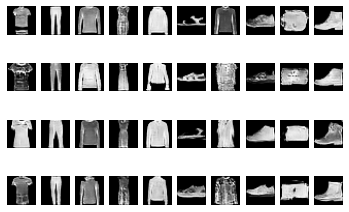

[0.35873883962631226, 0.828499972820282] 1.6809844970703125
78:0 [D loss: 0.35873883962631226] [G loss: 1.6809844970703125]


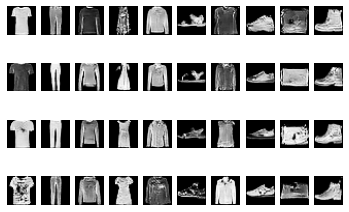

[0.34148064255714417, 0.843500018119812] 1.2922898530960083
79:0 [D loss: 0.34148064255714417] [G loss: 1.2922898530960083]


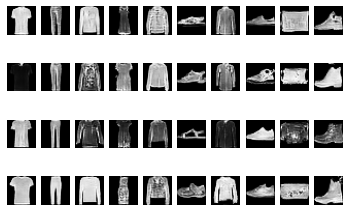

[0.3211123049259186, 0.8654999732971191] 2.8259449005126953
80:0 [D loss: 0.3211123049259186] [G loss: 2.8259449005126953]


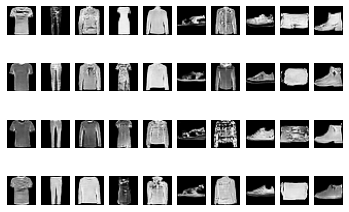

[0.30461347103118896, 0.8700000047683716] 1.6803663969039917
81:0 [D loss: 0.30461347103118896] [G loss: 1.6803663969039917]


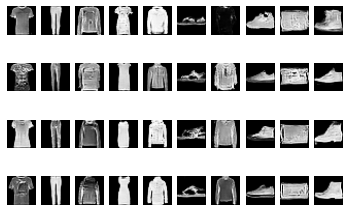

[0.2935445010662079, 0.8955000042915344] 1.9397797584533691
82:0 [D loss: 0.2935445010662079] [G loss: 1.9397797584533691]


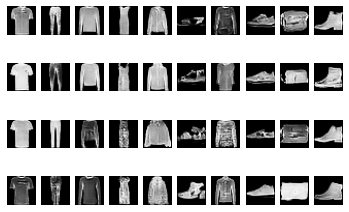

[0.3443509340286255, 0.8479999899864197] 2.9236950874328613
83:0 [D loss: 0.3443509340286255] [G loss: 2.9236950874328613]


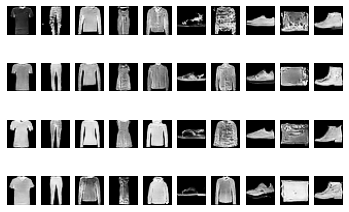

[0.29881981015205383, 0.8774999976158142] 2.163485288619995
84:0 [D loss: 0.29881981015205383] [G loss: 2.163485288619995]


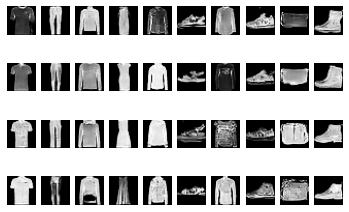

[0.31167230010032654, 0.8560000061988831] 1.7511472702026367
85:0 [D loss: 0.31167230010032654] [G loss: 1.7511472702026367]


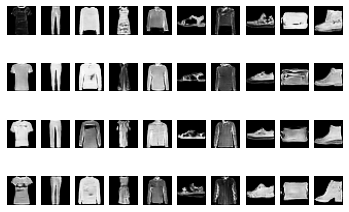

[0.3063875436782837, 0.8769999742507935] 2.3366951942443848
86:0 [D loss: 0.3063875436782837] [G loss: 2.3366951942443848]


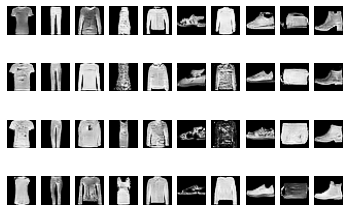

[0.30373087525367737, 0.862500011920929] 1.6374505758285522
87:0 [D loss: 0.30373087525367737] [G loss: 1.6374505758285522]


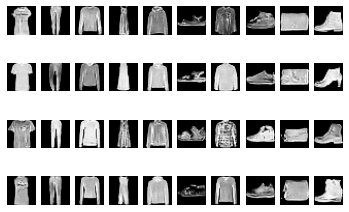

[0.3227141499519348, 0.8665000200271606] 2.761787176132202
88:0 [D loss: 0.3227141499519348] [G loss: 2.761787176132202]


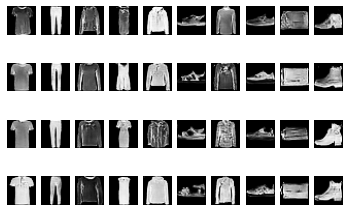

[0.2918092608451843, 0.8730000257492065] 2.215094566345215
89:0 [D loss: 0.2918092608451843] [G loss: 2.215094566345215]


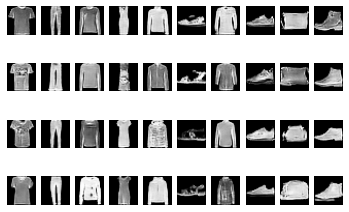

[0.29895153641700745, 0.8525000214576721] 1.481295108795166
90:0 [D loss: 0.29895153641700745] [G loss: 1.481295108795166]


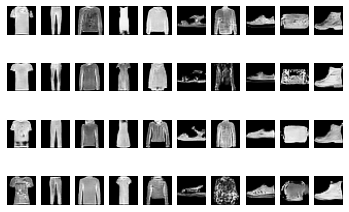

[0.3287922143936157, 0.8644999861717224] 3.972418785095215
91:0 [D loss: 0.3287922143936157] [G loss: 3.972418785095215]


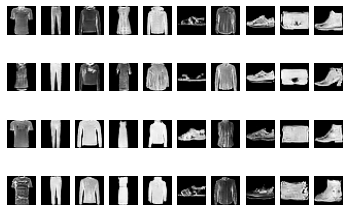

[0.27786871790885925, 0.8920000195503235] 2.7184505462646484
92:0 [D loss: 0.27786871790885925] [G loss: 2.7184505462646484]


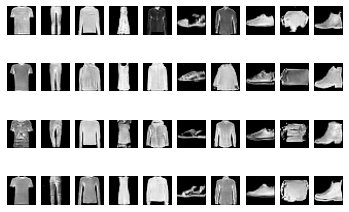

[0.2841845154762268, 0.8930000066757202] 2.6643118858337402
93:0 [D loss: 0.2841845154762268] [G loss: 2.6643118858337402]


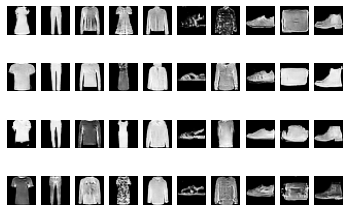

[0.29471972584724426, 0.875] 1.5376616716384888
94:0 [D loss: 0.29471972584724426] [G loss: 1.5376616716384888]


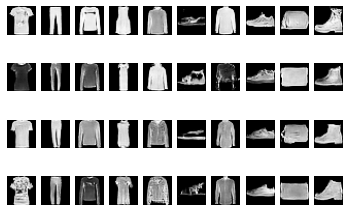

[0.3113427460193634, 0.8634999990463257] 1.5388344526290894
95:0 [D loss: 0.3113427460193634] [G loss: 1.5388344526290894]


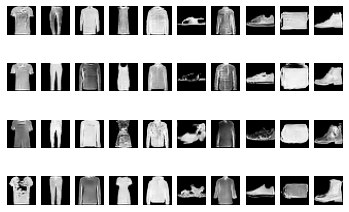

[0.2769079804420471, 0.8934999704360962] 1.9211485385894775
96:0 [D loss: 0.2769079804420471] [G loss: 1.9211485385894775]


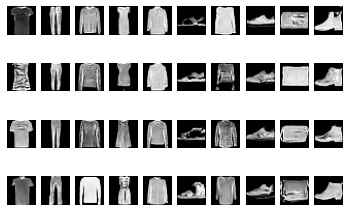

[0.26065921783447266, 0.8980000019073486] 2.176198959350586
97:0 [D loss: 0.26065921783447266] [G loss: 2.176198959350586]


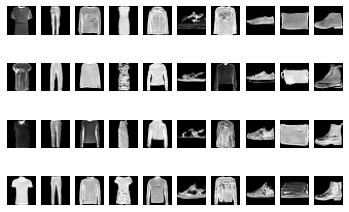

[0.2825251519680023, 0.890500009059906] 1.64579439163208
98:0 [D loss: 0.2825251519680023] [G loss: 1.64579439163208]


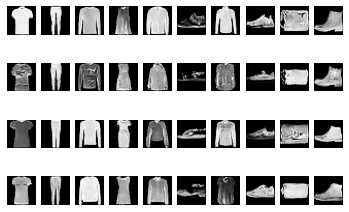

[0.24834124743938446, 0.9144999980926514] 1.8110601902008057
99:0 [D loss: 0.24834124743938446] [G loss: 1.8110601902008057]


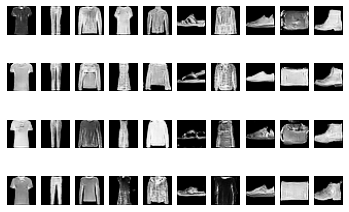

In [7]:
train(train_data, train_label)